In [455]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import concurrent.futures

# Preprocessing

In [456]:
pd.set_option('display.max_columns', None)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

### Scaling

In [457]:
def minmax_scaling(numerical_cols):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(numerical_cols)
    return scaled

In [458]:
def standard_scaling(numerical_cols):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(numerical_cols)
    return scaled

### Feature Selection

In [459]:
def corelation(feature, target):
    target = target.iloc[:, 0]
    c = feature.corrwith(target)
    # print(c.sort_values(ascending=False))
    top_features = c.abs().sort_values(ascending=False).head(20).index
    return top_features

In [460]:
def information_gain(feature, target):
    target = target.iloc[:, 0]
    ig = mutual_info_classif(feature, target)
    ig = pd.Series(ig, index=feature.columns)
    ig = ig.sort_values(ascending=False)
    # print(ig)
    top_features = ig.head(20).index
    return top_features

In [461]:
def onlinePreprocessing(df):
    # print(df.isnull().sum())
    df.dropna(subset=['y'], inplace=True)
    df.fillna(df.mean(), inplace=True)
    # print("No of duplicated rows: ",df.duplicated().sum())
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    features = df.drop('y', axis=1)
    target = df['y']
    # scaled_columns = minmax_scaling(features)
    scaled_columns = standard_scaling(features)
    features.loc[:, features.columns] = scaled_columns
    features = features.loc[:, features.nunique() > 1]
    df = pd.concat([features, target], axis=1)
    return df

# Data Input

In [462]:
def onlineInput():
    dataframe = pd.read_csv('B1.csv')
    # print(dataframe)
    X_prime = dataframe[['X1', 'X2']].values
    Y_prime = dataframe['y'].values
    dataframe_preprocessed = onlinePreprocessing(dataframe)
    x = dataframe_preprocessed.drop('y', axis=1)
    y = dataframe_preprocessed['y']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=60)
    # Plot the dataset (optional for visualization)
    plt.scatter(X_prime[Y_prime == 0][:, 0], X_prime[Y_prime == 0][:, 1], label='Class 0', alpha=0.6)
    plt.scatter(X_prime[Y_prime == 1][:, 0], X_prime[Y_prime == 1][:, 1], label='Class 1', alpha=0.6)
    plt.legend()
    plt.show()
    return x_train, x_test, y_train, y_test

# Logistic Regression

In [463]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.1, num_iterations=1000, decay_rate=0.01, regularization='l2', lambda_=0.1):
        self.initial_learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.decay_rate = decay_rate
        self.regularization = regularization
        self.lambda_ = lambda_
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        self.bias = 0

        for i in range(self.num_iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)

            dw = (1 / num_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / num_samples) * np.sum(y_predicted - y)

            if self.regularization == 'l1':
                dw += self.lambda_ * np.sign(self.weights)  # L1 regularization
            elif self.regularization == 'l2':
                dw += (self.lambda_ / num_samples) * self.weights  # L2 regularization

            learning_rate = self.initial_learning_rate / (1 + self.decay_rate * i)
            # learning_rate = self.initial_learning_rate
            self.weights -= learning_rate * dw
            self.bias -= learning_rate * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        y_classes = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_classes)


In [464]:
def calc_metrics(y_true, y_pred):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['senstivity'] = recall_score(y_true, y_pred)
    metrics['specificity'] = recall_score(y_true, y_pred, pos_label=0)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred)
    metrics['auroc'] = roc_auc_score(y_true, y_pred)
    metrics['aupr'] = average_precision_score(y_true, y_pred)
    return metrics

# Plot Violin Plots

In [465]:
def plot_violin_plot(all_metrics):
    all_metrics_df = pd.DataFrame(all_metrics)
    df_melted = all_metrics_df.melt(var_name='Metrics', value_name='Values')
    # pd.set_option('display.max_rows', None)
    # print(df_melted)
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Metrics', y='Values', data=df_melted)
    plt.title('Violin Plot of Metrics for Baseline Models')
    plt.show()

# Bagging

In [466]:
def bagging(X, Y, n_bags):
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

    regularizations = ['none', 'l1', 'l2']
    penalty = 0.01
    models = []
    base_learners_predictions = {} 
    metrics = {}

    for i in range(n_bags):
        x_sample, y_sample = resample(x_train, y_train, replace=True, n_samples=len(x_train), random_state=i)
        # regularization = regularizations[i % 3]
        # print("Bag : ", i, "Regularization: ", regularization)
        model = CustomLogisticRegression(learning_rate=0.1, num_iterations=1000, regularization='l2', lambda_=penalty)
        model.fit(x_sample, y_sample)
        models.append(model)
        y_pred = model.predict(x_val)
        base_learners_predictions[f'base_model_{i+1}'] = y_pred
        # np.set_printoptions(threshold=np.inf)
        # print("Bag : ", i, "Y: ", y_pred)
        m = calc_metrics(y_val, y_pred)
        for key in m:
            if key not in metrics:
                metrics[key] = []
            metrics[key].append(m[key])
            # print(key, m[key])
            
    plot_violin_plot(metrics)
    return models, base_learners_predictions 

# Stacking

In [467]:
def stacking(base_learners_predictions, X, Y ):
    base_learners_predictions_df = pd.DataFrame(base_learners_predictions).reset_index(drop=True)
    x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
    x_val = x_val.reset_index(drop=True)
    aug_x_val = pd.concat([x_val, base_learners_predictions_df], axis=1)
    # print(aug_x_val.shape)
    model = CustomLogisticRegression(learning_rate=0.1, num_iterations=1000, regularization='l2', lambda_=0.01)
    model.fit(aug_x_val, y_val)
    return model


# Majority Voting

In [468]:
def majority_voting(predictions):
    majority_votes = np.apply_along_axis(
        lambda x: np.bincount(x.astype(int)).argmax(), 
        axis=1, 
        arr=predictions
    )
    return majority_votes

# Work flow

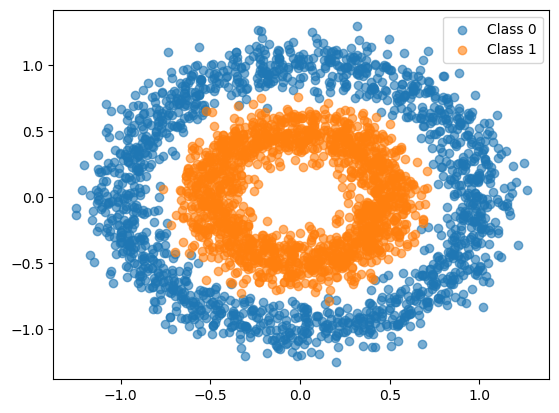

In [469]:
X_train, X_test, Y_train, Y_test = onlineInput()


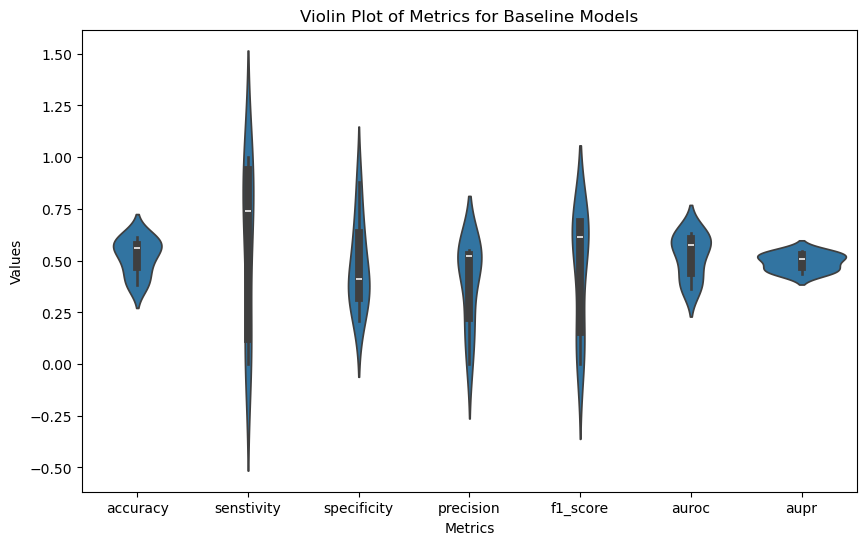

In [470]:
bagging_models,base_predictions = bagging(X_train, Y_train, 9)

In [471]:
LR_metrics = []
n = X_test.shape[0]
num_models = len(bagging_models)
predictions = np.zeros((n, num_models))
for i, model in enumerate(bagging_models):
    y_pred = model.predict(X_test)
    predictions[:, i] = y_pred
    LR_metrics.append(calc_metrics(Y_test, y_pred))

LR_metrics_summary = {key: [] for key in LR_metrics[0].keys()}
for metric in LR_metrics:
    for key in metric:
        LR_metrics_summary[key].append(metric[key])
final_LR_metrics = {key: (np.mean(values), np.std(values)) for key, values in LR_metrics_summary.items()}
print("Bagging Metrics: ", final_LR_metrics)


Bagging Metrics:  {'accuracy': (0.5231481481481483, 0.10367459909047463), 'senstivity': (0.5698005698005698, 0.3623568061060428), 'specificity': (0.47260802469135804, 0.19019866087191545), 'precision': (0.44424947115788743, 0.19872177435619517), 'f1_score': (0.4851881043911017, 0.2686409035855711), 'auroc': (0.521204297245964, 0.09341232789237806), 'aupr': (0.5437129987143877, 0.038044427935164216)}


In [472]:
majority_voting_pred = majority_voting(predictions)
majority_voting_metrics = calc_metrics(Y_test, majority_voting_pred)
print("Majority Voting Metrics: ", majority_voting_metrics)

Majority Voting Metrics:  {'accuracy': 0.58, 'senstivity': 0.6955128205128205, 'specificity': 0.4548611111111111, 'precision': 0.5802139037433155, 'f1_score': 0.6326530612244898, 'auroc': 0.5751869658119658, 'aupr': 0.5618795420266008}


In [473]:
meta_model = stacking(base_predictions, X_train, Y_train)
predictions_df = pd.DataFrame(predictions, columns=[f'Model_{i+1}' for i in range(num_models)])
predictions_df = predictions_df.reset_index(drop='true')
X_test = X_test.reset_index(drop=True)
aug_X_test = pd.concat([X_test, predictions_df], axis=1)
meta_model_pred = meta_model.predict(aug_X_test)
meta_model_metrics = calc_metrics(Y_test, meta_model_pred)
print("Stacking Metrics: ", meta_model_metrics)

Stacking Metrics:  {'accuracy': 0.81, 'senstivity': 0.7916666666666666, 'specificity': 0.8298611111111112, 'precision': 0.8344594594594594, 'f1_score': 0.8125, 'auroc': 0.8107638888888888, 'aupr': 0.768947072072072}


In [474]:
for metric in final_LR_metrics.keys():
        bagging_value = f"{final_LR_metrics[metric][0]:.4f} ± {final_LR_metrics[metric][1]:.4f}" if isinstance(final_LR_metrics[metric], tuple) else f"{final_LR_metrics[metric]:.4f}"
        majority_value = f"{majority_voting_metrics[metric]:.4f}"
        stacking_value = f"{meta_model_metrics[metric]:.4f}"
        print(f"{metric:<15} {bagging_value:<20} {majority_value:<20} {stacking_value:<20}")

accuracy        0.5231 ± 0.1037      0.5800               0.8100              
senstivity      0.5698 ± 0.3624      0.6955               0.7917              
specificity     0.4726 ± 0.1902      0.4549               0.8299              
precision       0.4442 ± 0.1987      0.5802               0.8345              
f1_score        0.4852 ± 0.2686      0.6327               0.8125              
auroc           0.5212 ± 0.0934      0.5752               0.8108              
aupr            0.5437 ± 0.0380      0.5619               0.7689              
